In [1]:
#Python libraries
import matplotlib.pyplot as plt 
import MetaTrader5 as mt5
import tensorflow as tf
import numpy as np
import pandas as pd
import tf2onnx
from sklearn.model_selection import train_test_split
from sys import argv

In [2]:
#check tensorflow version
print(tf.__version__)

2.10.0


In [3]:
#check GPU support
print(len(tf.config.list_physical_devices('GPU'))>0)

True


In [4]:
#initialize MetaTrader5 for history data
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

In [5]:
terminal_info=mt5.terminal_info()

In [6]:
#show file path
file_path=terminal_info.data_path+"\\MQL5\\Files\\"

In [7]:
#data path to save the model
data_path=argv[0]
last_index=data_path.rfind("\\")+1
data_path=data_path[0:last_index]

In [8]:
#set start and end dates for history data
from datetime import timedelta,datetime
end_date = datetime.now()
start_date = end_date - timedelta(days=120)

#print start and end dates
print("data start date=",start_date)
print("data end date=",end_date)

data start date= 2022-11-28 12:28:39.870685
data end date= 2023-03-28 12:28:39.870685


In [9]:
#get EURUSD rates (H1) from start_date to end_date
eurusd_rates = mt5.copy_rates_range("EURUSD", mt5.TIMEFRAME_H1, start_date, end_date)

In [10]:
#check
print(eurusd_rates)

[(1669633200, 1.04392, 1.04567, 1.0433 , 1.04477, 7955, 0, 0)
 (1669636800, 1.04477, 1.0482 , 1.04388, 1.04742, 6616, 0, 0)
 (1669640400, 1.04742, 1.04969, 1.04719, 1.04743, 7527, 0, 0) ...
 (1679986800, 1.08151, 1.08153, 1.081  , 1.08123, 1766, 0, 0)
 (1679990400, 1.08122, 1.08163, 1.08063, 1.08103, 2092, 0, 0)
 (1679994000, 1.08103, 1.0819 , 1.0808 , 1.08082, 3814, 0, 0)]


In [11]:
#create dataframe
df = pd.DataFrame(eurusd_rates)

In [12]:
#show dataframe head
df.head()

,time,open,high,low,close,tick_volume,spread,real_volume
0,1669633200,1.04392,1.04567,1.04330,1.04477,7955,0,0
1,1669636800,1.04477,1.04820,1.04388,1.04742,6616,0,0
2,1669640400,1.04742,1.04969,1.04719,1.04743,7527,0,0
3,1669644000,1.04744,1.04775,1.04589,1.04729,6675,0,0
4,1669647600,1.04729,1.04768,1.04442,1.04629,7916,0,0


In [13]:
#show dataframe tail
df.tail()

,time,open,high,low,close,tick_volume,spread,real_volume
2040,1679979600,1.08149,1.08178,1.08108,1.08139,2103,0,0
2041,1679983200,1.08139,1.08179,1.08121,1.08151,1897,0,0
2042,1679986800,1.08151,1.08153,1.08100,1.08123,1766,0,0
2043,1679990400,1.08122,1.08163,1.08063,1.08103,2092,0,0
2044,1679994000,1.08103,1.08190,1.08080,1.08082,3814,0,0


In [14]:
#show dataframe shape (the number of rows and columns in the data set)
df.shape

(2045, 8)

In [15]:
#prepare close prices only
data = df.filter(['close']).values

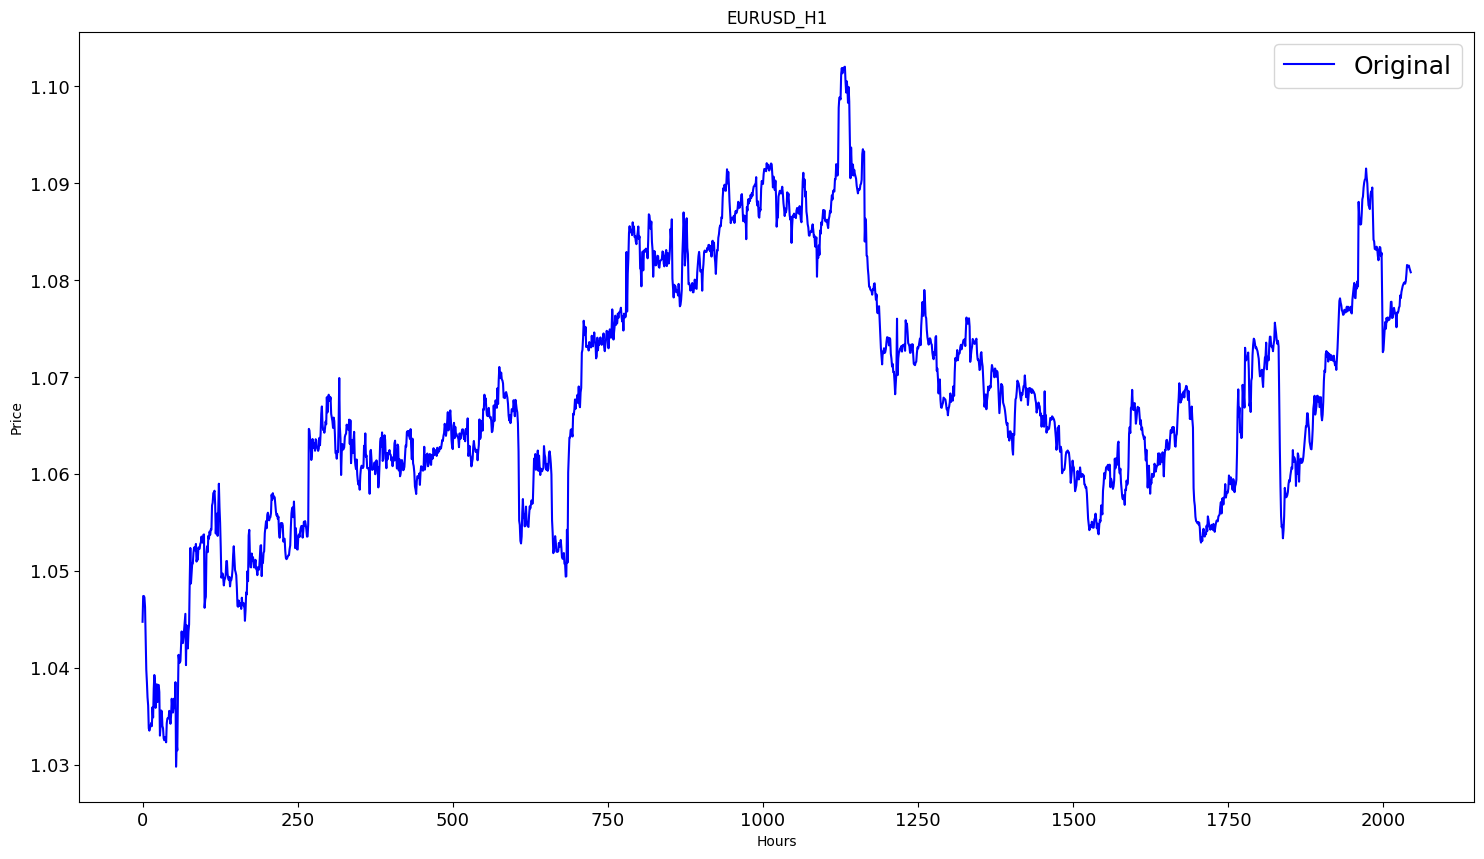

In [16]:
#show close prices
plt.figure(figsize = (18,10))
plt.plot(data,'b',label = 'Original')
plt.xlabel("Hours")
plt.xticks(fontsize=13)
plt.ylabel("Price")
plt.yticks(fontsize=13)
plt.title("EURUSD_H1")
plt.legend(fontsize=18)

In [17]:
#scale data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [18]:
#training size is 80% of the data
training_size = int(len(scaled_data)*0.80) 
print("training size:",training_size)

training size: 1636


In [19]:
#create train data and check size
train_data_initial = scaled_data[0:training_size,:]
print(len(train_data_initial))

1636


In [20]:
#create test data and check size
test_data_initial= scaled_data[training_size:,:1]
print(len(test_data_initial))

409


In [21]:
#split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
       #find the end of this pattern
       end_ix = i + n_steps
       #check if we are beyond the sequence
       if end_ix > len(sequence)-1:
          break
       #gather input and output parts of the pattern
       seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
       X.append(seq_x)
       y.append(seq_y)
    return np.array(X), np.array(y)

In [22]:
#split into samples
time_step = 120
x_train, y_train = split_sequence(train_data_initial, time_step)
x_test, y_test = split_sequence(test_data_initial, time_step)

In [23]:
#reshape input to be [samples, time steps, features] which is required for LSTM
x_train =x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [24]:
#show shape of train data
x_train.shape

(1516, 120, 1)

In [25]:
#show shape of test data
x_test.shape

(289, 120, 1)

In [26]:
#import keras libraries for the model
import math
from keras.models import Sequential
from keras.layers import Dense,Activation,Conv1D,MaxPooling1D,Dropout
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model
from keras.metrics import RootMeanSquaredError as rmse
from keras import optimizers

In [27]:
#define the model
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2,activation='relu',padding = 'same',input_shape=(120,1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences = False))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation = 'sigmoid'))
model.compile(optimizer='adam', loss= 'mse' , metrics = [rmse()])

In [28]:
#show model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 120, 256)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 60, 256)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 60, 100)           142800    
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                        

In [29]:
#measure time
import time 
time_calc_start = time.time()

#fit model with 300 epochs
history=model.fit(x_train,y_train,epochs=300,validation_data=(x_test,y_test),batch_size=32,verbose=1)

#calculate time
fit_time_seconds = time.time() - time_calc_start
print("fit time =",fit_time_seconds," seconds.")

Epoch 1/300
48/48 [==============================] - 8s 49ms/step - loss: 0.0129 - root_mean_squared_error: 0.1136 - val_loss: 0.0065 - val_root_mean_squared_error: 0.0804
Epoch 2/300
48/48 [==============================] - 2s 32ms/step - loss: 0.0028 - root_mean_squared_error: 0.0526 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0640
Epoch 3/300
48/48 [==============================] - 2s 35ms/step - loss: 0.0020 - root_mean_squared_error: 0.0442 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0534
Epoch 4/300
48/48 [==============================] - 2s 37ms/step - loss: 0.0018 - root_mean_squared_error: 0.0428 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0498
Epoch 5/300
48/48 [==============================] - 2s 33ms/step - loss: 0.0015 - root_mean_squared_error: 0.0389 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0430
Epoch 6/300
48/48 [==============================] - 2s 33ms/step - loss: 0.0012 - root_mean_squared_error: 0.0348 - val_loss: 0.0018 - val_

Epoch 47/300
48/48 [==============================] - 1s 31ms/step - loss: 5.4687e-04 - root_mean_squared_error: 0.0234 - val_loss: 4.8996e-04 - val_root_mean_squared_error: 0.0221
Epoch 48/300
48/48 [==============================] - 1s 30ms/step - loss: 5.9456e-04 - root_mean_squared_error: 0.0244 - val_loss: 5.0375e-04 - val_root_mean_squared_error: 0.0224
Epoch 49/300
48/48 [==============================] - 1s 29ms/step - loss: 5.2459e-04 - root_mean_squared_error: 0.0229 - val_loss: 4.4415e-04 - val_root_mean_squared_error: 0.0211
Epoch 50/300
48/48 [==============================] - 1s 29ms/step - loss: 6.0142e-04 - root_mean_squared_error: 0.0245 - val_loss: 4.8158e-04 - val_root_mean_squared_error: 0.0219
Epoch 51/300
48/48 [==============================] - 2s 31ms/step - loss: 5.5054e-04 - root_mean_squared_error: 0.0235 - val_loss: 4.6460e-04 - val_root_mean_squared_error: 0.0216
Epoch 52/300
48/48 [==============================] - 1s 30ms/step - loss: 5.2045e-04 - root_me

48/48 [==============================] - 2s 35ms/step - loss: 5.1970e-04 - root_mean_squared_error: 0.0228 - val_loss: 4.7235e-04 - val_root_mean_squared_error: 0.0217
Epoch 138/300
48/48 [==============================] - 1s 30ms/step - loss: 4.4379e-04 - root_mean_squared_error: 0.0211 - val_loss: 4.1942e-04 - val_root_mean_squared_error: 0.0205
Epoch 139/300
48/48 [==============================] - 1s 30ms/step - loss: 4.2047e-04 - root_mean_squared_error: 0.0205 - val_loss: 4.4584e-04 - val_root_mean_squared_error: 0.0211
Epoch 140/300
48/48 [==============================] - 2s 35ms/step - loss: 5.0748e-04 - root_mean_squared_error: 0.0225 - val_loss: 5.1868e-04 - val_root_mean_squared_error: 0.0228
Epoch 141/300
48/48 [==============================] - 1s 31ms/step - loss: 4.6753e-04 - root_mean_squared_error: 0.0216 - val_loss: 4.4074e-04 - val_root_mean_squared_error: 0.0210
Epoch 142/300
48/48 [==============================] - 1s 30ms/step - loss: 4.6240e-04 - root_mean_squar

48/48 [==============================] - 1s 29ms/step - loss: 4.5128e-04 - root_mean_squared_error: 0.0212 - val_loss: 4.3142e-04 - val_root_mean_squared_error: 0.0208
Epoch 228/300
48/48 [==============================] - 1s 29ms/step - loss: 4.3736e-04 - root_mean_squared_error: 0.0209 - val_loss: 4.4743e-04 - val_root_mean_squared_error: 0.0212
Epoch 229/300
48/48 [==============================] - 1s 30ms/step - loss: 4.6221e-04 - root_mean_squared_error: 0.0215 - val_loss: 4.2876e-04 - val_root_mean_squared_error: 0.0207
Epoch 230/300
48/48 [==============================] - 2s 32ms/step - loss: 4.3075e-04 - root_mean_squared_error: 0.0208 - val_loss: 4.1232e-04 - val_root_mean_squared_error: 0.0203
Epoch 231/300
48/48 [==============================] - 1s 30ms/step - loss: 4.2300e-04 - root_mean_squared_error: 0.0206 - val_loss: 4.8532e-04 - val_root_mean_squared_error: 0.0220
Epoch 232/300
48/48 [==============================] - 1s 30ms/step - loss: 4.6614e-04 - root_mean_squar

In [30]:
#show training history keys
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

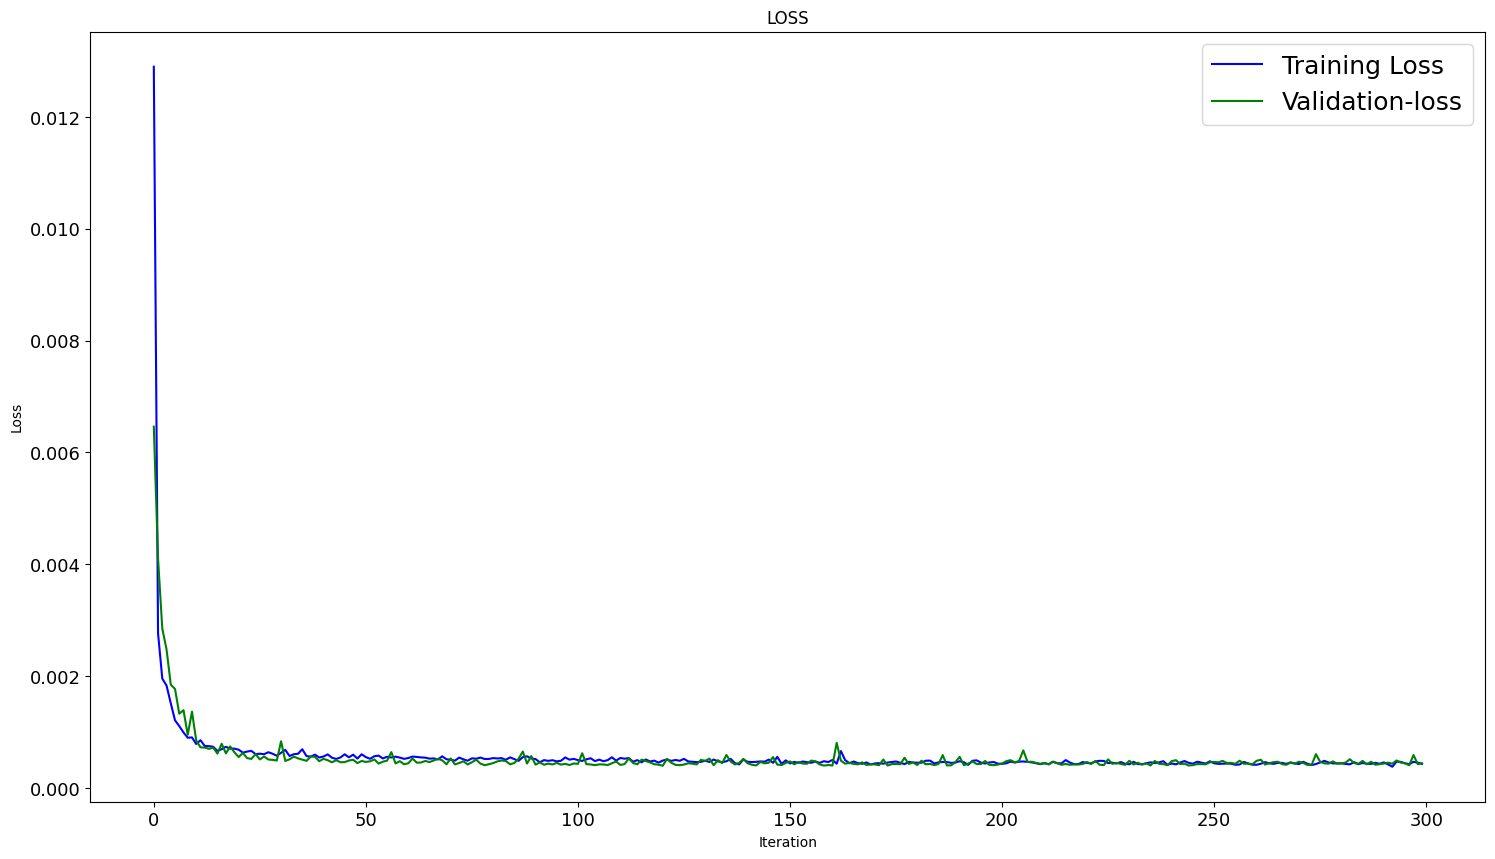

In [31]:
#show iteration-loss graph for training and validation
plt.figure(figsize = (18,10))
plt.plot(history.history['loss'],label='Training Loss',color='b')
plt.plot(history.history['val_loss'],label='Validation-loss',color='g')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("LOSS")
plt.legend(fontsize=18)

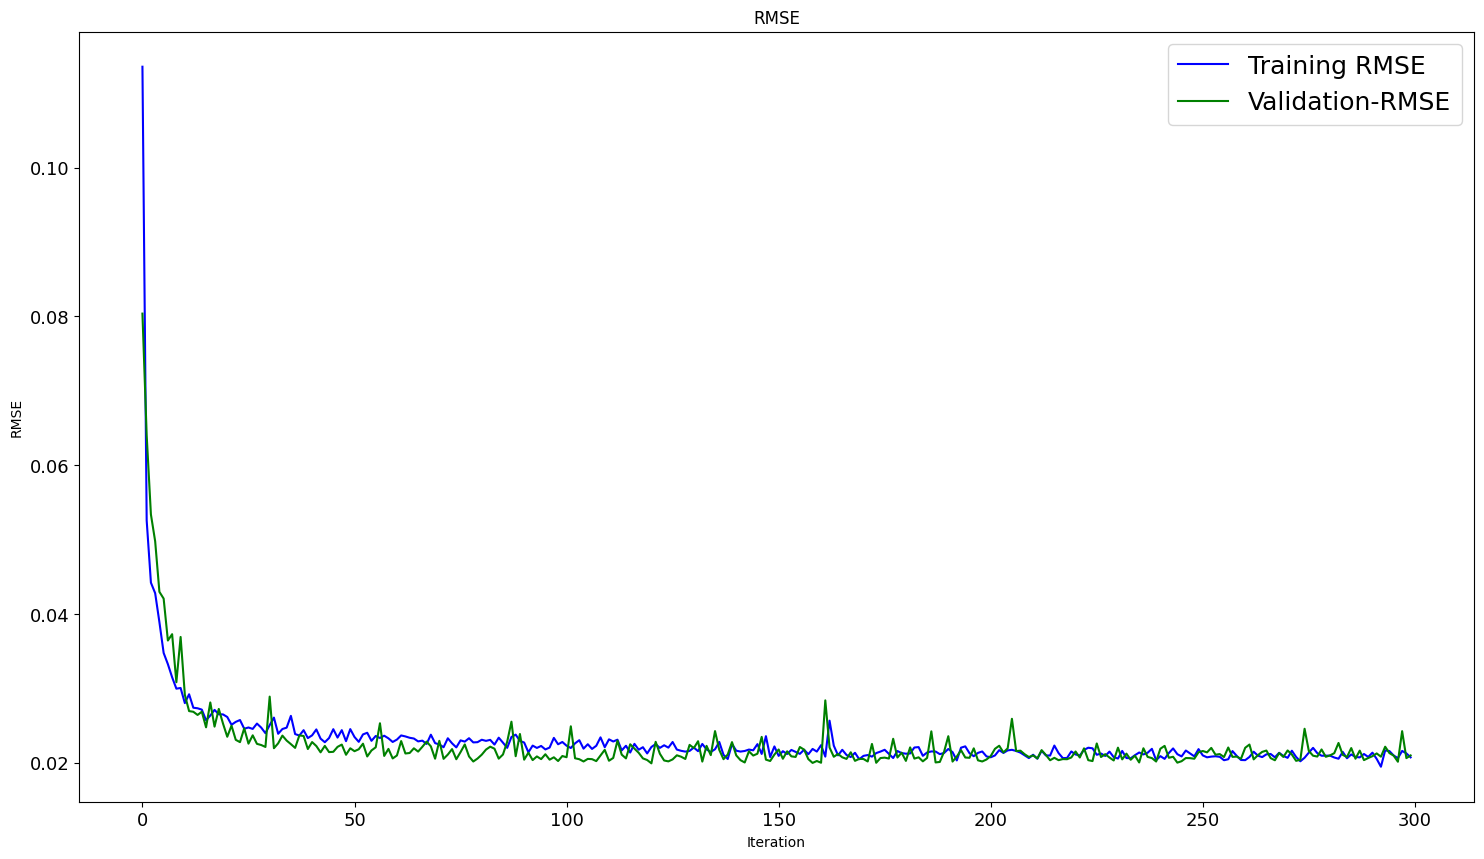

In [32]:
#show iteration-rmse graph for training and validation
plt.figure(figsize = (18,10))
plt.plot(history.history['root_mean_squared_error'],label='Training RMSE',color='b')
plt.plot(history.history['val_root_mean_squared_error'],label='Validation-RMSE',color='g')
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("RMSE")
plt.legend(fontsize=18)

In [33]:
#evaluate training data
model.evaluate(x_train,y_train, batch_size = 32)

48/48 [==============================] - 1s 22ms/step - loss: 2.9911e-04 - root_mean_squared_error: 0.0173


[0.00029911252204328775, 0.01729486882686615]

In [34]:
#evaluate testing data
model.evaluate(x_test,y_test, batch_size = 32)

10/10 [==============================] - 0s 31ms/step - loss: 4.4040e-04 - root_mean_squared_error: 0.0210


[0.00044039846397936344, 0.020985672250390053]

In [35]:
#prediction using training data
train_predict = model.predict(x_train)
plot_y_train = y_train.reshape(-1,1)

48/48 [==============================] - 2s 18ms/step


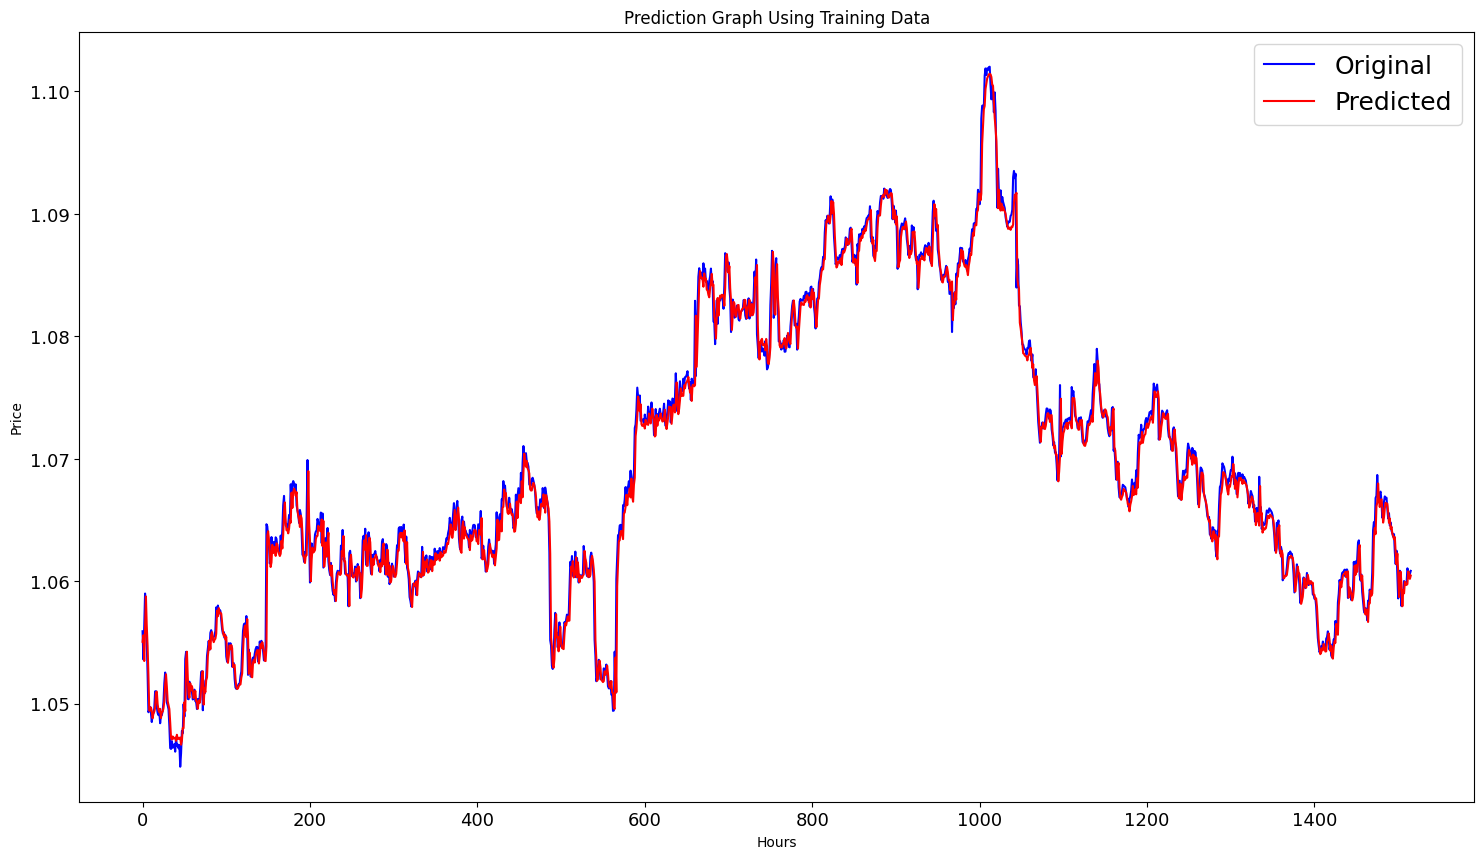

In [36]:
#show actual vs predicted (training) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_train),color = 'b', label = 'Original')
plt.plot(scaler.inverse_transform(train_predict),color='red', label = 'Predicted')
plt.title("Prediction Graph Using Training Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=18)
plt.show()

In [37]:
#prediction using testing data
test_predict = model.predict(x_test)
plot_y_test = y_test.reshape(-1,1)

10/10 [==============================] - 0s 27ms/step


In [38]:
#calculate metrics
from sklearn import metrics
from sklearn.metrics import r2_score
#transform data to real values
value1=scaler.inverse_transform(plot_y_test)
value2=scaler.inverse_transform(test_predict)
#calc score
score = np.sqrt(metrics.mean_squared_error(value1,value2))
print("RMSE         : {}".format(score))
print("MSE          :", metrics.mean_squared_error(value1,value2))
print("R2 score     :",metrics.r2_score(value1,value2))

RMSE         : 0.0015151631684117558
MSE          : 2.295719426911551e-06
R2 score     : 0.9683533377809039


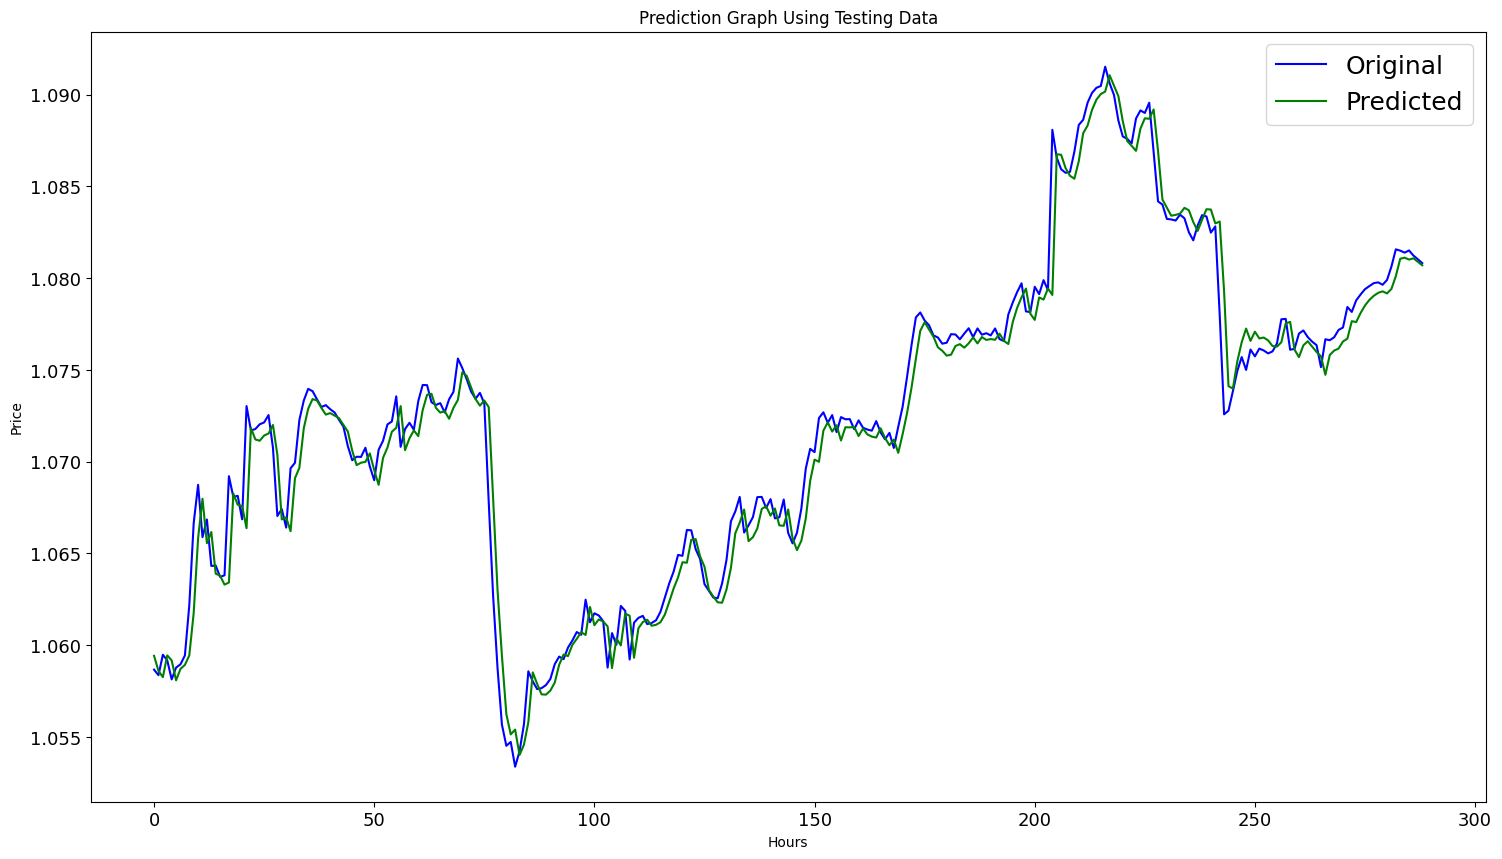

In [39]:
#show actual vs predicted (testing) graph
plt.figure(figsize=(18,10))
plt.plot(scaler.inverse_transform(plot_y_test),color = 'b',  label = 'Original')
plt.plot(scaler.inverse_transform(test_predict),color='g', label = 'Predicted')
plt.title("Prediction Graph Using Testing Data")
plt.xlabel("Hours")
plt.ylabel("Price")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=18)
plt.show()

In [40]:
# save model to ONNX
output_path = data_path+"model.eurusd.H1.120.onnx"
onnx_model = tf2onnx.convert.from_keras(model, output_path=output_path)

In [46]:
# finish
mt5.shutdown()

True